# Playing with random networks learning 

A very silly idea, perhaps silly enough? 

Readings: 
- the physics of NNs https://indico.cern.ch/event/1218225/contributions/5380943/attachments/2642491/4574761/Pheno%20Talk.pdf 
- Implicit Regularization of Random Feature Models https://arxiv.org/pdf/2002.08404.pdf


In [1]:
%ls

play.ipynb


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import OrthogonalMatchingPursuit, LinearRegression
import random
import copy
import os
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.convert_parameters import parameters_to_vector, vector_to_parameters



/local/home/glanzillo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_deterministic(seed):
    print(f" --- Seed set to {seed} ---")
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled=False
    torch.backends.cudnn.deterministic=True
    np.random.seed(seed)
    random.seed(seed)
    return

In [4]:
get_deterministic(11)

 --- Seed set to 11 ---


## Datasets

We start by using the MNIST dataset (for simplicity) 

In [5]:
def MNIST(dataroot):
    # Add padding to make 32x32
    normalize = transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # for 28x28

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    train_transform = val_transform

    train_dataset = torchvision.datasets.MNIST(
        root=dataroot,
        train=True,
        download=True,
        transform=train_transform
    )
    
    val_dataset = torchvision.datasets.MNIST(
        dataroot,
        train=False,
        transform=val_transform
    )
    
    return train_dataset, val_dataset

In [6]:
data_path="../continually/data"
train, val = MNIST(data_path)

In [7]:
def extract_labels(data, num_classes, device='cpu', encoding=False):
    """ Returns a binary matrix with one-hot encoded labels."""
    labels = []
    for (_,y) in data: 
        labels.append(y)
    labels = torch.Tensor(labels).to(torch.long).to(device)
    if encoding: 
        labels = F.one_hot(labels, num_classes).byte() # we save x8 storage with conversion to .byte()
    return labels

In [8]:
Y_val = extract_labels(val, num_classes=10, encoding=True)
print(Y_val.element_size()*Y_val.nelement())

100000


In [9]:
Y_train = extract_labels(train, num_classes=10, encoding=True)
print(Y_train.element_size()*Y_train.nelement())

600000


## Networks

We start with a simple MLP

In [10]:
GPU = 1
if torch.cuda.is_available(): device = torch.device(GPU)
else: device = torch.device("cpu")

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=f"{GPU}"

In [11]:
class MLP(nn.Module):

    def __init__(self, output_dim, input_dim, hidden_dim=256, num_hidden_layers=3, **kwargs):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.bias = kwargs.get('bias',True)
        dims = [input_dim] + [hidden_dim]*num_hidden_layers 
        layers = []
        for l in range(num_hidden_layers):
            layers.append(nn.Linear(dims[l], dims[l+1], bias=self.bias))
            layers.append(nn.ReLU(inplace=True))
        self.features = nn.Sequential(*layers)
        self.last = nn.Linear(hidden_dim, output_dim, bias=self.bias)

        print(sum(p.numel() for p in self.parameters()), "parameters")

    def logits(self, z):
        z = self.last(z)
        return z

    def forward(self, x, normalised=True, t=1.0):
        x = self.features(x)
        x = self.logits(x)
        if normalised: x = F.softmax(x/t, dim=1)
        return x

    @staticmethod
    def init_weights(m):
        # pytorch initialisations: https://pytorch.org/docs/stable/nn.init.html 
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            #torch.nn.init.uniform_(m.weight, a = -1., b = 1.)
            #torch.nn.init.normal_(m.weight, mean = 0.0, std = 1.)
            #torch.nn.init.xavier_normal_(m.weight, gain=np.sqrt(2))
            #torch.nn.init.orthogonal_(m.weight, gain=1.)
            #torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            #torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            m.bias.data.fill_(0.01)

        

In [12]:
input_dim = 28**2
net = MLP(10, input_dim, num_hidden_layers=3, hidden_dim=200)
net.apply(net.init_weights)
net = net.to(device)

239410 parameters


In [13]:
# testing wether the initialisation function works
net.apply(net.init_weights)
theta = parameters_to_vector(net.parameters())
net.apply(net.init_weights)
theta_prime = parameters_to_vector(net.parameters())
torch.norm(theta-theta_prime)

tensor(38.3533, device='cuda:1', grad_fn=<CopyBackwards>)

In [14]:
# generating a random net basis
K = 1000
B = []
for _ in range(K):
    net.apply(net.init_weights)
    with torch.no_grad(): B.append(parameters_to_vector(net.parameters()).to(device))
B = torch.vstack(B)

In [17]:
def heatmap(M, title, step=20):
    fig = plt.figure(figsize=(5,5), dpi=300)
    plt.imshow(M.cpu(), cmap='hot', interpolation='nearest')
    ax = plt.gca()
    # AESTHETICS control 
    fig.set_facecolor("black")
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ticks = list(range(0,K+1,step))
    plt.yticks(ticks)
    plt.xticks(ticks)

    #ax.minorticks_on()
    ax.grid(which='major', color='gray', linewidth=0)
    ax.grid(which='minor', color='silver', linestyle=':', linewidth=0.6)
    ax.tick_params(axis='x', colors='whitesmoke')
    ax.tick_params(axis='y', colors='whitesmoke')

    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')

    ax.set_title(title)
    ax.title.set_color('white')
    #plt.tight_layout()
    plt.show()
    return fig 


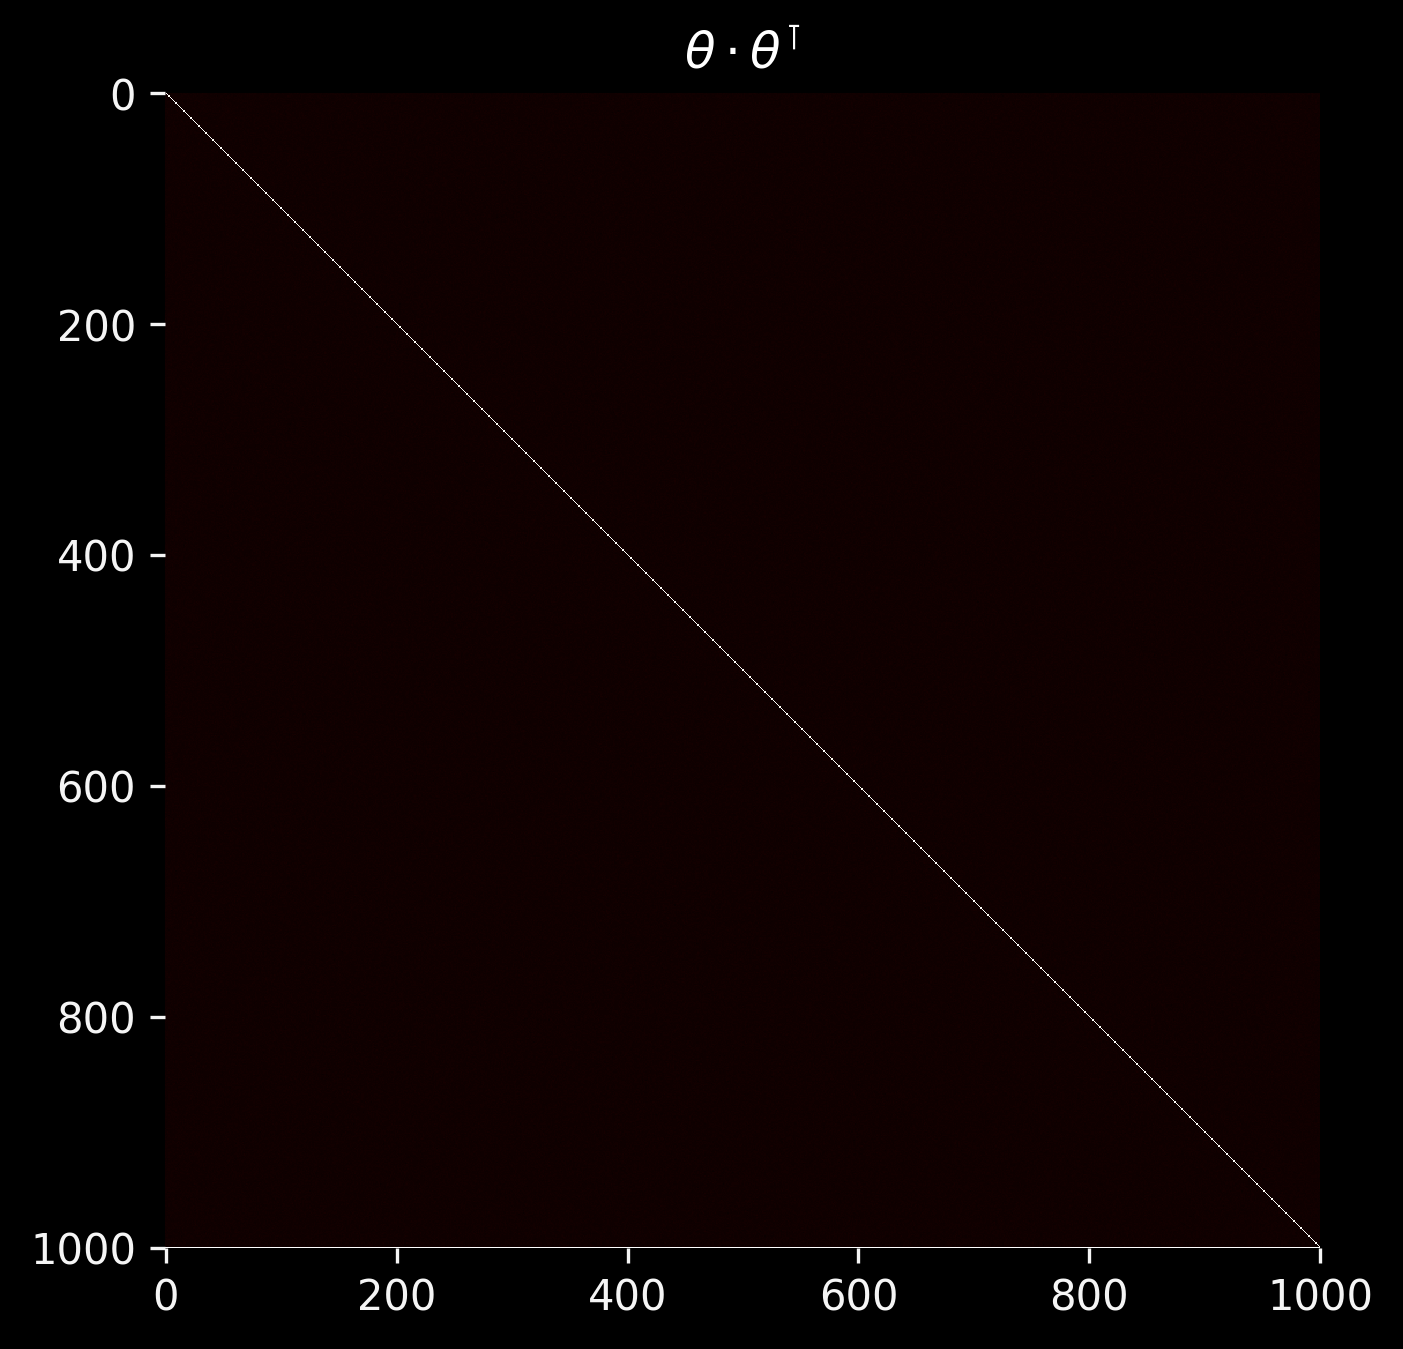

In [18]:
B2 = torch.matmul(B,B.T)/torch.norm(B)**2
B2.shape

heatmap(B2, title=r'$\theta \cdot \theta^\intercal$', step=200);

## Learning algorithm

Basically divided in two steps \
(1) generate random net basis and obtain prediction vectors \
(2) apply matching pursuit to it - see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html 

In [19]:
K = 1000 # what is the dimensionality of MNIST? 
K_star = 100 # number of used elements in MP
M = 128 # batch size of the data loader
epsilon = 0.000001 # error threshold

### Part I

In [252]:
#TODO: device checking
#TODO: test reproducibility

In [20]:
T = 0.0001 # temperature

In [21]:
def generate_random_net_basis(num_elements, net):
    B = []
    for _ in range(K):
        net.apply(net.init_weights)
        net.eval()
        B.append(copy.deepcopy(net))
    return B

In [22]:
B = generate_random_net_basis(K, net)

In [23]:
def get_random_output_basis(net_basis, data_loader):
    # generating a random output basis
    yB = []
    for i in tqdm(range(len(net_basis))):
        outputs = []
        net = net_basis[i]
        for (x,_) in data_loader: 
            x = x.reshape(-1, net.input_dim).to(device)
            with torch.no_grad(): outputs.append(net.forward(x, normalised=False, t=T))
        outputs = torch.vstack(outputs)
        yB.append(outputs)
    yB = torch.stack(yB)

    return yB

In [24]:
train_loader = DataLoader(train, batch_size=M, shuffle=False, num_workers=10,  pin_memory=False)
val_loader = DataLoader(val, batch_size=M, shuffle=False, num_workers=10,  pin_memory=False)

In [25]:
yB = get_random_output_basis(B, train_loader)

100%|██████████| 1000/1000 [25:04<00:00,  1.50s/it]


In [26]:
yB.shape

torch.Size([1000, 60000, 10])

In [43]:
# checking the rank 
#print(np.mean([np.linalg.matrix_rank(yB.cpu().permute((1,0,2))[i]) for i in range(60000)]))
#print(np.linalg.matrix_rank(yB.permute((1,0,2)).reshape(60000,-1)))
print(np.linalg.matrix_rank(yB.cpu().reshape(K,-1)))

195


torch.Size([1000, 1000])


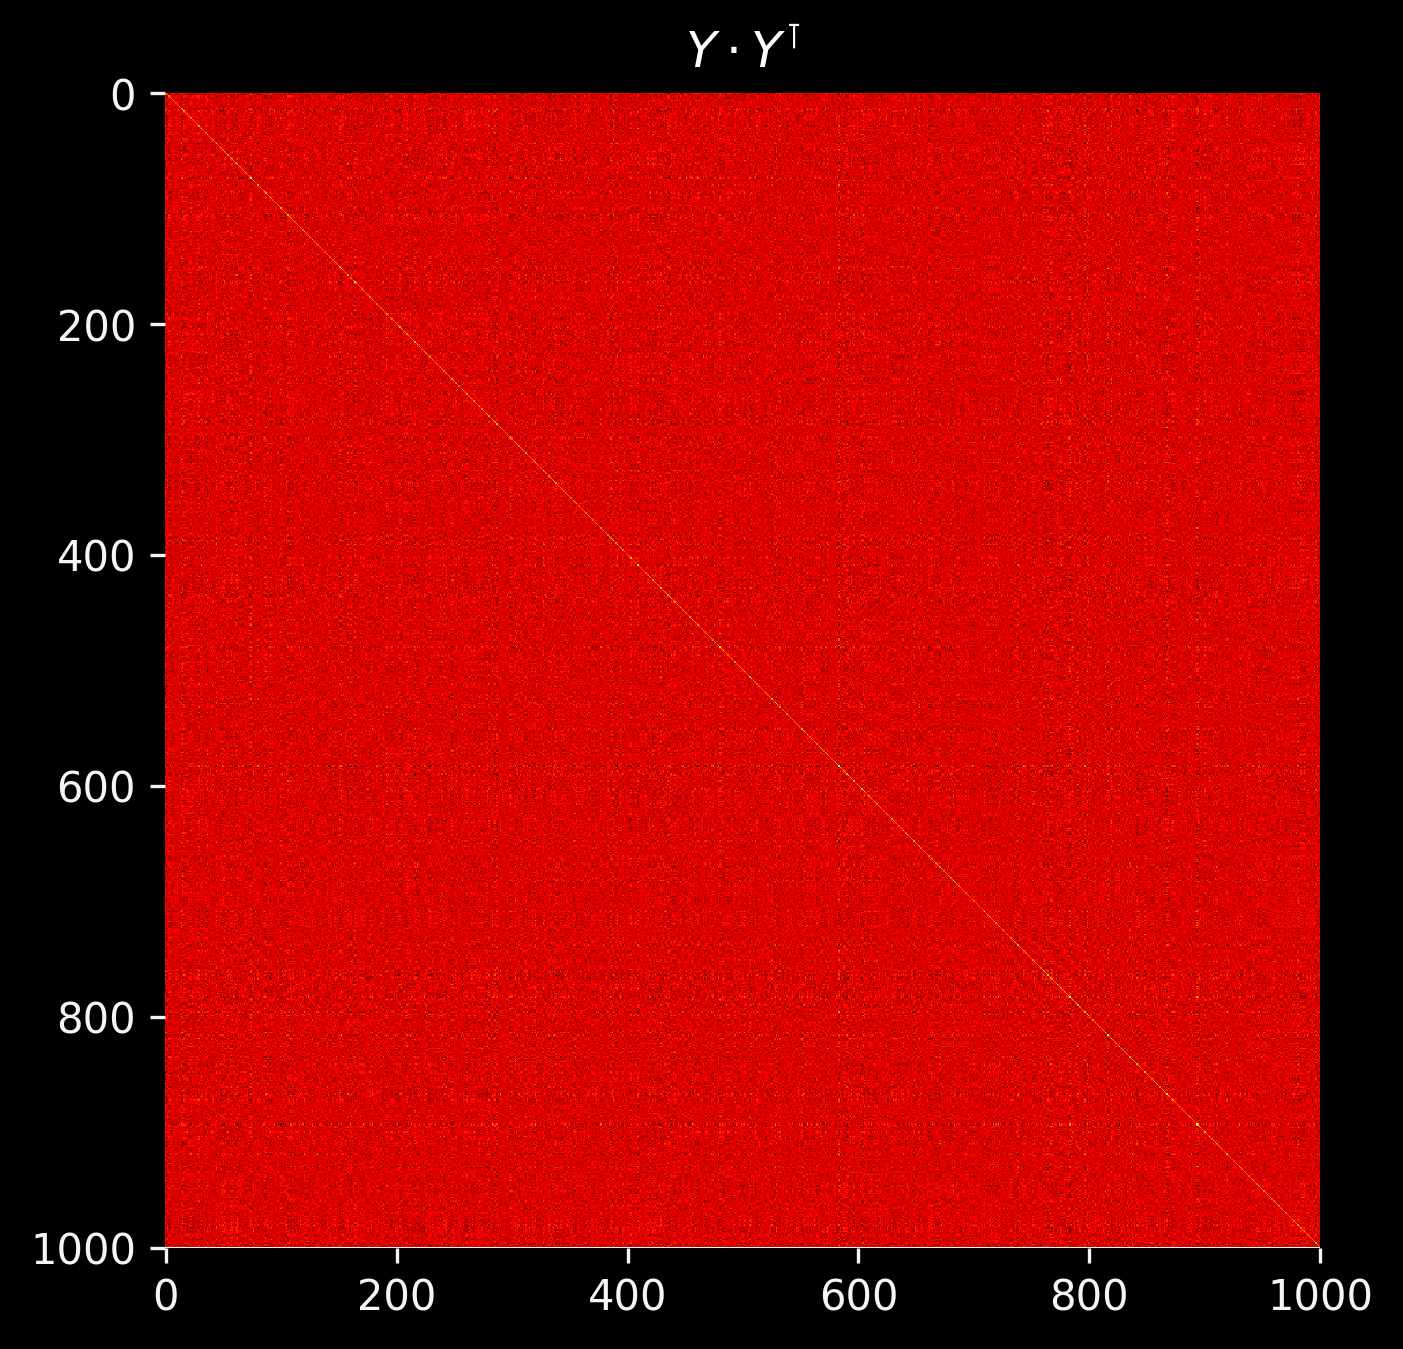

In [27]:
yB2 = torch.matmul(yB.reshape(K,-1),yB.reshape(K,-1).T)/torch.norm(yB.reshape(K,-1))**2
print(yB2.shape)

heatmap(yB2, title=r'$Y \cdot Y^\intercal$', step=200);

### Part II

In [28]:
yB.shape, Y_train.shape


(torch.Size([1000, 60000, 10]), torch.Size([60000, 10]))

In [29]:
# first we normalise the inputs 
#X = (yB/torch.norm(yB, dim=2).view(*yB.shape[:2],1)).reshape(-1,K)
X = yB.reshape(K,-1).T
#X = yB[:,:,0].T
#X = X/torch.norm(X, dim=0).view(-1,K)
#X = X/torch.norm(X, dim=1).view(-1,1)
Y = Y_train.reshape(-1).to(torch.float)
#Y = Y_train[:,0].to(torch.float)
#X = X*torch.norm(Y)


In [32]:
reg = LinearRegression().fit(X.cpu(), Y.cpu())
print(reg.score(X.cpu(), Y.cpu()))
alpha = reg.coef_
print(reg.intercept_)

0.4631374904770462
0.12110453


In [114]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K_star, tol=epsilon, fit_intercept=True, normalize=True)
omp.fit(X, Y) #dimension check: N x K, N x 1
alpha = omp.coef_

/local/home/glanzillo/.local/lib/python3.10/site-packages/sklearn/linear_model/_omp.py:757: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  coef_, self.n_iter_ = orthogonal_mp_gram(


<StemContainer object of 3 artists>

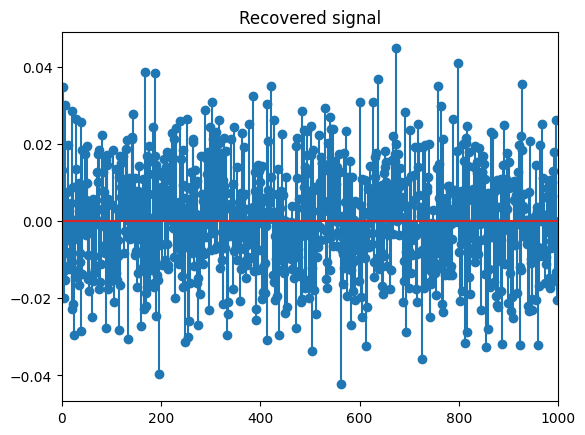

In [33]:
(idx_r,) = alpha.nonzero()
plt.xlim(0, K)
plt.title("Recovered signal")
plt.stem(idx_r, alpha[idx_r])


In [36]:
prediction = torch.matmul(torch.Tensor(alpha), X.T.cpu())
# train accuracy
_, pred = torch.max(prediction.reshape(Y_train.shape[0],Y_train.shape[1]), 1)
_, label = torch.max(Y_train, 1)
correct = torch.sum(pred == label).item()
total = Y_train.shape[0]                
acc=(correct / total) * 100
acc

80.47833333333332

### Now evaluating on validation data

In [39]:
yB_val = get_random_output_basis(B, val_loader)

100%|██████████| 1000/1000 [14:41<00:00,  1.13it/s]


In [40]:
prediction = torch.matmul(torch.Tensor(alpha), yB_val.cpu().reshape(K,-1))

In [41]:
prediction.shape, Y_val.shape

(torch.Size([100000]), torch.Size([10000, 10]))

In [42]:
prediction = torch.matmul(torch.Tensor(alpha), yB_val.cpu().reshape(K,-1))
# validation accuracy
_, pred = torch.max(prediction.reshape(Y_val.shape[0],Y_val.shape[1]), 1)
_, label = torch.max(Y_val, 1)
correct = torch.sum(pred == label).item()
total = Y_val.shape[0]                
acc=(correct / total) * 100
acc

81.65